# Trabalho Prático Interação e Concorrência

Group 20:<br>
Pedro Simão Lemos Silva - A85625 <br>
Bruno Alexandre Dias Novais de Sousa - A84945

Each group of students has a number assigned, $N$. Now, you have to use
a quantum algorithm to find $s$, 
<br>
<br>
<center> $s = N \mod 8$ </center>
<br>
in an unsorted list.

In [35]:
# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, transpile

from qiskit.tools.visualization import plot_histogram, plot_state_city, plot_state_hinton

import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
backend_vector = Aer.get_backend("statevector_simulator")
backend = Aer.get_backend("qasm_simulator")
backend_unitary = Aer.get_backend('unitary_simulator')

Since the number assigned to our group was the number $20$, the number $s$ that we need to find is

In [3]:
N = 20
s = N % 8
s

4

Since $s = 4$, that implies that we need to localize it in a list, where $s$ is the only value equal to $1$, with the other values being $0$.<br>
Also we will only need $3$ qubits, because the list length can be $2^{3} = 8$.<br> 
With this two informations, we know the list could be represented by the vector of $| 100 \rangle$.

In [4]:
qr_solucao = QuantumRegister(3,'qr')
cr_solucao = ClassicalRegister(3,'cr')
qc_solucao = QuantumCircuit(qr_solucao,cr_solucao);  
qc_solucao.x(qr_solucao[2])
result = execute(qc_solucao, backend_vector).result()
qstate= result.get_statevector(qc_solucao)
print(qstate)

[0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]


Now that we know our number $s$, lets get to the quantum algorithm.

In [5]:
qr = QuantumRegister(3,'qr')
cr = ClassicalRegister(3,'cr')

Then we create a quantum circuit

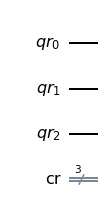

In [6]:
qc_init = QuantumCircuit(qr,cr)
qc_init.draw(output='mpl')

## Initialization

In this stage we need to put all of the qubits with the same amplitude, so we want the qubits to be in a superposition state.

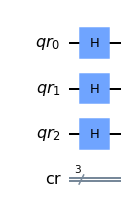

In [7]:
qc_init.h(qr)
qc_init.draw(output='mpl')

### Initialization Simulator


In this case, since the initial state of the qubits that make up the circuit is $| 000 \rangle$, after the Hadamard gate, their state turns to $| +_2 \rangle \otimes | +_1 \rangle \otimes | +_0 \rangle$ in which $| + \rangle =\frac{| 0 \rangle + | 1 \rangle }{\sqrt{2}}$.
<br>
After calculations, we get the state vector:

In [8]:
result = execute(qc_init, backend_vector).result()
qstate= result.get_statevector(qc_init)
print(qstate)

[0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j
 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j]


Since in this step we got every input possible at the same amplitude( as we can see above), now we need to apply a Oracle followed by a Diffuser, a $\sqrt{T}$ times, where $T$ is the number of inputs, $T = 8$.

## Oracle


The purpose of the oracle is to find the target and indicate it.
It's in this step that we want the amplitude of the target to differ from the other inputs.
So the better way of achieving that goal, is by tring to change $s$'s amplitude to a negative value while keeping every other input value the same.

So with that in mind, let's try it, using an oracle similiar to what was used in the pretical classes.

Knowing the previous state of the qubits,

In [9]:
print(qstate)

[0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j
 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j]


**(1)** We start by adding a X gate to $qr_0$ and $qr_1$.<br>
$~~~~$The position of the X gates influences the position of the target. As we are trying to find the target, is important to put a X gate in the qubit that you want as $| 0 \rangle$, in this example, we put the X gates in the first two qubits because we want the $| 100 \rangle$ state.<br>
$~~~~$Basically the only non-zero value in the last column of the **Unitary Vector** of this two X gates, will turn negative by the CCZ, identifying the target value, depending on the line that value is located.

<ipython-input-10-7cce1a73a425>:2: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  qc = qc_init + qc
/home/simao/anaconda3/lib/python3.8/site-packages/qiskit/circuit/quantumcircuit.py:869: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  return self.combine(rhs)


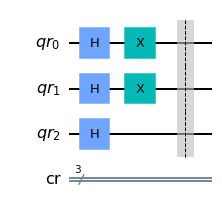

In [10]:
qc = QuantumCircuit(qr,cr)
qc = qc_init + qc
qc_3 = QuantumCircuit(qr,cr)
qc_3.x(qr[0])
qc_3.x(qr[1])
qc_3.barrier()
qc = qc + qc_3
qc.draw(output='mpl')

In [11]:
result = execute(qc, backend_vector).result()
qstate= result.get_statevector(qc)
print(qstate)

[0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j
 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j]


**(2)** We add a CCZ gate, but as we can't put a CCZ because we have $3$ qubits, we can use a CCX gate with control qubits in $qr_0$ and $qr_1$, and $qr_2$ as target qubit, sided by a Hadamard gate in each side **(Z = HXH)**.<br>
$~~~~$We add a CCZ gate to turn the only non-zero value in the last column of the **Unitary Vector** of the last X gates into negative, making it the only negative value of the **Unitary Vector** of this gates.


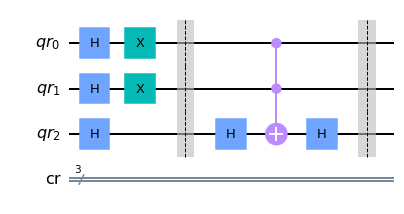

In [12]:
qc_4 = QuantumCircuit(qr,cr)
qc_4.h(qr[2])
qc_4.ccx(qr[0],qr[1],qr[2])
qc_4.h(qr[2])
qc_4.barrier()
qc = qc + qc_4
qc.draw(output='mpl')

In [13]:
result = execute(qc, backend_vector).result()
qstate= result.get_statevector(qc)
print(qstate)

[ 0.35355339-3.37871389e-33j  0.35355339+1.50786785e-33j
  0.35355339+1.50786785e-33j  0.35355339-4.32978028e-17j
  0.35355339-4.32978028e-17j  0.35355339-4.32978028e-17j
  0.35355339-4.32978028e-17j -0.35355339+8.65956056e-17j]


**(3)** We add a X gate to $qr_0$ and $qr_1$.<br>
$~~~~$This makes the **Unitary Vector** return into a similiar state to the one we started with, the Identity, with the only being the negative value in the target line.<br>
$~~~~$This way we can easily locate where our $s$ is.

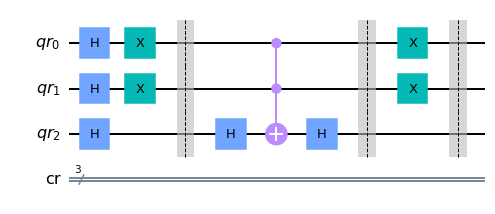

In [14]:
qc = qc + qc_3
qc.draw(output='mpl')

In [15]:
result = execute(qc, backend_vector).result()
qstate = result.get_statevector(qc)
print(qstate)

[ 0.35355339-4.32978028e-17j  0.35355339+1.50786785e-33j
  0.35355339+1.50786785e-33j  0.35355339-3.37871389e-33j
 -0.35355339+8.65956056e-17j  0.35355339-4.32978028e-17j
  0.35355339-4.32978028e-17j  0.35355339-4.32978028e-17j]


As we see, after the execution of the oracle, we end up with a negative amplitude in $s$, successfully finding our target.

To show the matrix produced by the oracle only, and how simple it is, we are using **UnitarySimulator** to show that the unitary matrix ends up being pretty similiar with the Identity matrix, with the exception of the position $[s,s]$, where the value is negative, keeping the values in the diagonal.

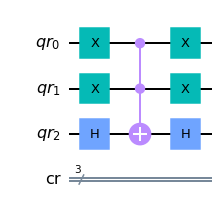

In [17]:
qc_test1 = QuantumCircuit(qr,cr)
phase_oracle(qc_test1,qr)
qc_test1.draw(output='mpl')

In [18]:
job = execute(qc_test1, backend_unitary)
result = job.result()
unitary_matrix = result.get_unitary(qc_test1, decimals=3)

# Show the results
print(unitary_matrix)

[[ 1.-0.j  0.+0.j  0.+0.j  0.+0.j -0.-0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.-0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.-0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.-0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [-0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.-0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.-0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.-0.j]]


Since we now know how to build a suitable oracle for the problem, we can organize its code.

In [16]:
def select_w(circuit, qr_x):
    circuit.x(qr_x[0])
    circuit.x(qr_x[1])

def phase_oracle(circuit, qr_x):
    select_w(circuit,qr_x)
    circuit.h(qr_x[2])
    circuit.ccx(qr_x[0],qr_x[1],qr_x[2])
    circuit.h(qr_x[2])
    select_w(circuit,qr_x)

## Amplification

As the meaning of the word says, in this stage we want to increase the amplitude of the target, while decreasing the other inputs amplitude. 

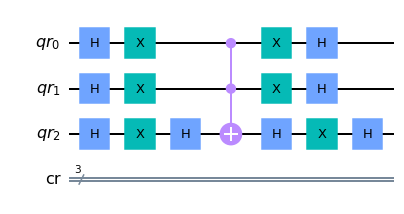

In [20]:
qc_5 = QuantumCircuit(qr,cr)
diffuser(qc_5,qr)
qc_5.draw(output='mpl')

In [22]:
job = execute(qc_5, backend_unitary)
result = job.result()
unitary_matrix = result.get_unitary(qc_5, decimals=3)

# Show the results
print(unitary_matrix)

[[ 0.75-0.j -0.25+0.j -0.25+0.j -0.25+0.j -0.25-0.j -0.25-0.j -0.25-0.j
  -0.25-0.j]
 [-0.25+0.j  0.75-0.j -0.25+0.j -0.25+0.j -0.25-0.j -0.25-0.j -0.25-0.j
  -0.25+0.j]
 [-0.25+0.j -0.25+0.j  0.75-0.j -0.25+0.j -0.25-0.j -0.25-0.j -0.25-0.j
  -0.25-0.j]
 [-0.25+0.j -0.25+0.j -0.25+0.j  0.75-0.j -0.25+0.j -0.25+0.j -0.25+0.j
  -0.25+0.j]
 [-0.25-0.j -0.25-0.j -0.25-0.j -0.25-0.j  0.75+0.j -0.25-0.j -0.25-0.j
  -0.25-0.j]
 [-0.25-0.j -0.25-0.j -0.25-0.j -0.25+0.j -0.25-0.j  0.75+0.j -0.25-0.j
  -0.25-0.j]
 [-0.25-0.j -0.25+0.j -0.25+0.j -0.25+0.j -0.25-0.j -0.25-0.j  0.75+0.j
  -0.25-0.j]
 [-0.25+0.j -0.25+0.j -0.25+0.j -0.25+0.j -0.25-0.j -0.25+0.j -0.25+0.j
   0.75+0.j]]


As we can see using the **UnitarySimulator**, the unitary vector has a positive value in his diagonal, and negative everywhere else. Since the state vector after the oracle comes with only one negative target value, this makes all the values of the state vector negative, but makes the target value a "bigger negative" number, while the other become a "smaller negative" number.

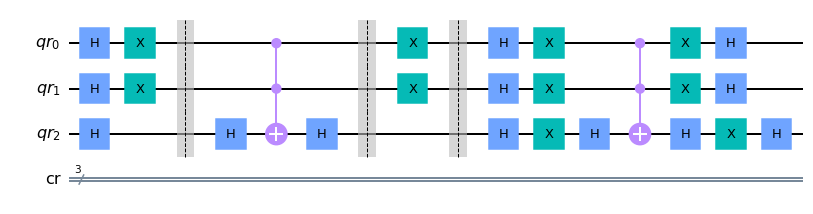

In [21]:
qc = qc + qc_5
qc.draw(output='mpl')

In [23]:
result = execute(qc, backend_vector).result()
qstate = result.get_statevector(qc)
print(qstate)

[ 0.35355339-4.32978028e-17j  0.35355339+1.50786785e-33j
  0.35355339+1.50786785e-33j  0.35355339-3.37871389e-33j
 -0.35355339+8.65956056e-17j  0.35355339-4.32978028e-17j
  0.35355339-4.32978028e-17j  0.35355339-4.32978028e-17j]


Like it was said above, the target value is easily located, due to it being the "biggest" of all the negative numbers in the state vector.<br>
One thing we can notice is that the target value is very close to $|1|$ and all of the others, close to $0$, meaning that is the most probable that we reach $| 100 \rangle$, instead of the other possible states( as we will see bellow).

In [24]:
def diffuser(circuit, qr_x):
    circuit.h(qr_x)
    circuit.x(qr_x)
    circuit.h(qr_x[2])
    circuit.ccx(qr_x[0],qr_x[1],qr_x[2]) 
    circuit.h(qr_x[2])
    circuit.x(qr_x)
    circuit.h(qr_x)

## Oracle and Amplification Cycle

Now we just need to execute the cycle $\sqrt{8}$ times, i.e around 2 times.

### Cycle with 1 iteration


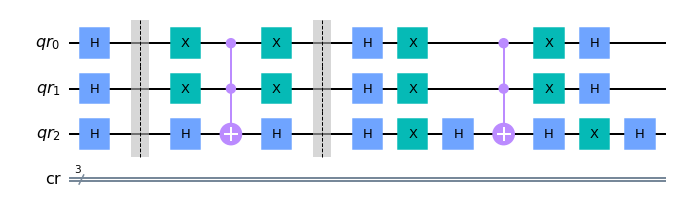

In [25]:
qc_final = QuantumCircuit(qr,cr)
qc_final = qc_init + qc_final
for t in range(1):
    # phase oracle 
    qc_final.barrier()
    phase_oracle(qc_final,qr)
    # diffuser
    qc_final.barrier()
    diffuser(qc_final,qr)

qc_final.draw(output='mpl')

#### State Vector Simulator

In [26]:
result = execute(qc_final, backend_vector).result()
qstate = result.get_statevector(qc_final)
print(qstate)

[-0.1767767 -4.32978028e-17j -0.1767767 +2.16489014e-17j
 -0.1767767 +2.16489014e-17j -0.1767767 +4.32978028e-17j
 -0.88388348-8.39715590e-17j -0.1767767 -8.09098269e-18j
 -0.1767767 -8.09098269e-18j -0.1767767 +5.68557215e-17j]


#### Noise Simulator

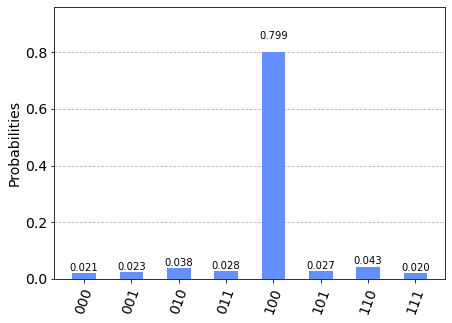

In [27]:
qc_final.measure(qr,cr)

shots=1024
result = execute(qc_final, backend, shots=shots).result()
counts_sim = result.get_counts(qc_final)
plot_histogram(counts_sim)

### Cycle with 2 iterations

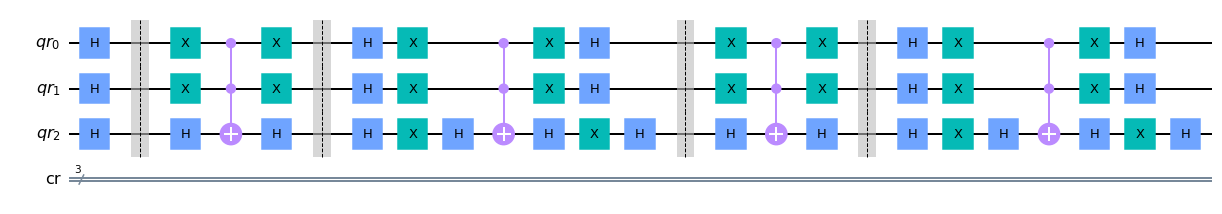

In [28]:
qc_final2 = QuantumCircuit(qr,cr)
qc_final2 = qc_init + qc_final2
for t in range(2):
    # phase oracle 
    qc_final2.barrier()
    phase_oracle(qc_final2,qr)
    # diffuser
    qc_final2.barrier()
    diffuser(qc_final2,qr)


qc_final2.draw(output='mpl')

#### State Vector Simulator

In [29]:
result = execute(qc_final2, backend_vector).result()
qstate = result.get_statevector(qc_final2)
print(qstate)

[-0.08838835-2.03368781e-17j -0.08838835-9.51242737e-18j
 -0.08838835-9.51242737e-18j -0.08838835+2.29609247e-17j
  0.97227182+1.24645315e-16j -0.08838835-3.79402881e-17j
 -0.08838835-3.79402881e-17j -0.08838835-2.71158374e-17j]


#### Noise Simulator

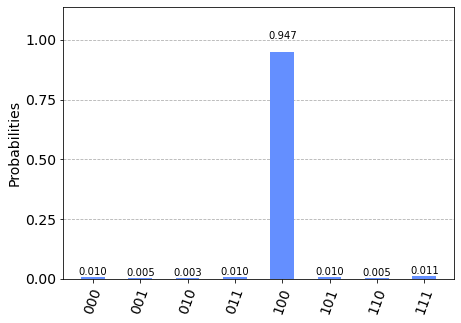

In [63]:
qc_final2.measure(qr,cr)

shots=1024
result = execute(qc_final2, backend, shots=shots).result()
counts_sim2 = result.get_counts(qc_final2)
plot_histogram(counts_sim2)

### Cycle with 3 iterations

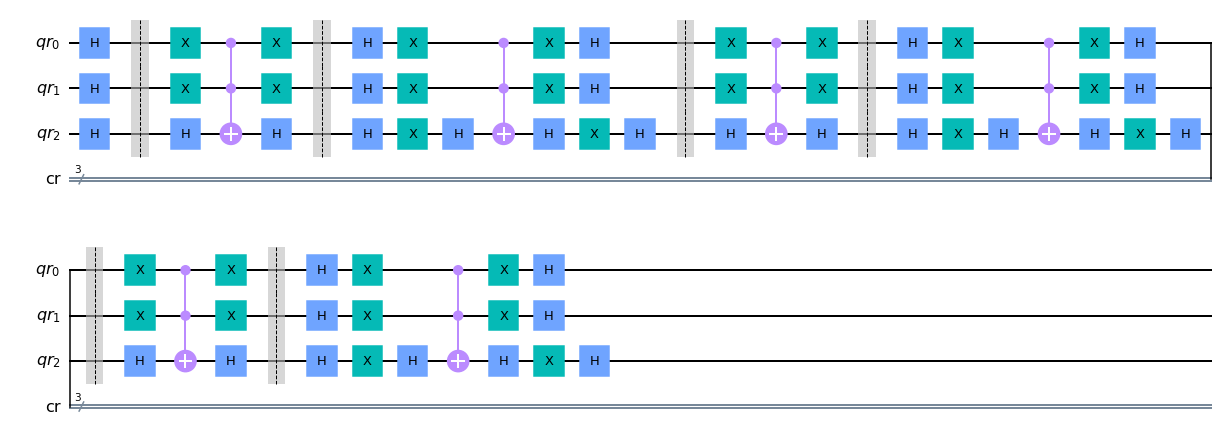

In [31]:
qc_final3 = QuantumCircuit(qr,cr)
qc_final3 = qc_init + qc_final3
for t in range(3):
    # phase oracle 
    qc_final3.barrier()
    phase_oracle(qc_final3,qr)
    # diffuser
    qc_final3.barrier()
    diffuser(qc_final3,qr)

qc_final3.draw(output='mpl')

#### State Vector Simulator

In [32]:
result = execute(qc_final3, backend_vector).result()
qstate = result.get_statevector(qc_final3)
print(qstate)

[ 0.30935922-1.34484974e-17j  0.30935922+1.36126294e-17j
  0.30935922+1.36126294e-17j  0.30935922+8.20040404e-18j
 -0.57452426-1.03652425e-16j  0.30935922+1.29566177e-17j
  0.30935922+1.29566177e-17j  0.30935922+4.00177445e-17j]


#### Noise Simulator

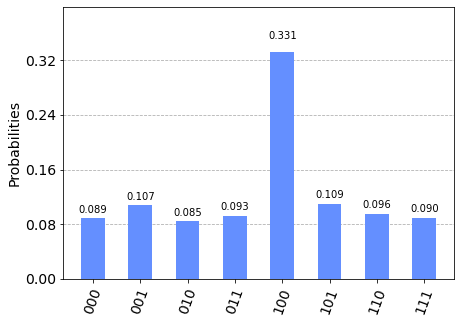

In [33]:
qc_final3.measure(qr,cr)

shots=1024
result = execute(qc_final3, backend, shots=shots).result()
counts_sim = result.get_counts(qc_final3)
plot_histogram(counts_sim)

With the above, we can conclude that the best optimisation is when we use 2 iterations of the cycle.<br>
Apart from the Noise simulator, in which we can clearly see what is the best decision, the state vector simulator help us find what is the best option.

And like that, with this algorithm implementation, we can reach a very high probability of finding our target value, in this case, $| 100 \rangle$ or $4$ in decimal.

## Run in a quantum computer


In [43]:
provider = IBMQ.load_account()
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') fr

In [44]:
# Backend overview
import qiskit.tools.jupyter

%qiskit_backend_overview

In [45]:
from qiskit.tools.monitor import backend_overview, backend_monitor

backend_overview()

ibmq_manila                  ibmq_quito                   ibmq_belem
-----------                  ----------                   ----------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  5
Pending Jobs: 9              Pending Jobs: 15             Pending Jobs: 3
Least busy:   False          Least busy:   False          Least busy:   False
Operational:  True           Operational:  True           Operational:  True
Avg. T1:      140.4          Avg. T1:      84.8           Avg. T1:      78.1
Avg. T2:      67.9           Avg. T2:      74.6           Avg. T2:      77.5



ibmq_lima                    ibmq_santiago                ibmq_athens
---------                    -------------                -----------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  5
Pending Jobs: 7              Pending Jobs: 10             Pending Jobs: 6
Least busy:   False          Least busy:   False          Least busy:   False
Operational:  True           Operati

Out of curiosity let's run the circuit in 2 different backends to see if we can see the difference between them. For this purpose, we will choose backends with quite different decoherence times and readout error rate.

### IBMQ Santiago

In [87]:
backend_device = provider.get_backend('ibmq_santiago')
print("Running on: ", backend_device)

Running on:  ibmq_santiago


In [88]:
backend_device

<IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>

In [59]:
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [89]:
job_r = execute(qc_final2, backend_device, shots=shots)

jobID_r = job_r.job_id()

print('JOB ID: {}'.format(jobID_r))

JOB ID: 60ba38405f4eaac33fdadc02


In [90]:
job_get=backend_device.retrieve_job("60ba38405f4eaac33fdadc02")

result_r_santiago = job_get.result()
counts_run_santiago = result_r_santiago.get_counts(qc_final2)

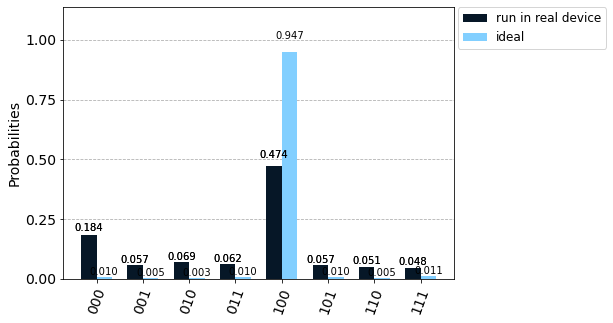

In [91]:
plot_histogram([counts_run_santiago, counts_sim2 ], legend=[ 'run in real device', 'ideal'], color=['#061727','#82cfff'])

### IBMQ Lima

In [68]:
backend_device = provider.get_backend('ibmq_lima')
print("Running on: ", backend_device)

Running on:  ibmq_lima


In [69]:
backend_device

<IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>

In [70]:
job_r = execute(qc_final2, backend_device, shots=shots)

jobID_r = job_r.job_id()

print('JOB ID: {}'.format(jobID_r))

JOB ID: 60ba337b5f4eaa0be9dadbc5


In [71]:
job_get=backend_device.retrieve_job("60ba337b5f4eaa0be9dadbc5")

result_r = job_get.result()
counts_run = result_r.get_counts(qc_final2)

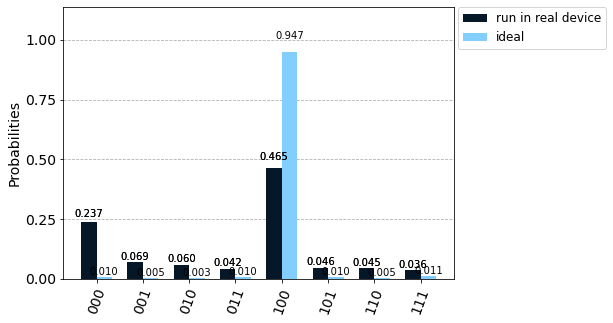

In [72]:
plot_histogram([counts_run, counts_sim2 ], legend=[ 'run in real device', 'ideal'], color=['#061727','#82cfff'])

After executing our circuit on both backends, we can notice the "ibmq_santiago" gives us better results, this is because it has better decoherence times and a smaller readout error rate than the "ibmq_lima" backend.

## IGNIS

Now we want to mitigate the measurement errors, so we will use the IGNIS tool to help us.

In [93]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

### Calibration Matrices

First, we need to generate a list of measurement calibration circuits.
Since there we measure 3 qubits, we need $2^3 = 8$ calibration circuits.

In [105]:
qr = QuantumRegister(3)

meas_calibs, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr, circlabel='mcal')

In [95]:
state_labels

['000', '001', '010', '011', '100', '101', '110', '111']

#### Computing the calibration matrix

With the next step, we will be able to notice the device noise. We will achieve that by gathering the measured results and using the list of measurement calibration, to generate a matrix similiar with the Identity matrix, where on diagonal is filled with the black color and the rest with white, with the only difference in this case the position where it was supposed to be white, might have shades of grey, indicating noise interference. 

In [96]:
backend_device = provider.get_backend('ibmq_santiago')
print("Running on: ", backend_device)

Running on:  ibmq_santiago


In [97]:
job_ignis = execute(meas_calibs, backend=backend_device, shots=shots)

jobID_run_ignis = job_ignis.job_id()

print('JOB ID: {}'.format(jobID_run_ignis))

JOB ID: 60ba38ecfe8ff1f1a929d824


In [100]:
job_get=backend_device.retrieve_job("60ba38ecfe8ff1f1a929d824")

cal_results = job_get.result()

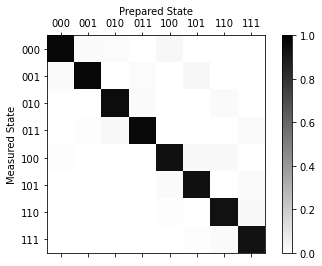

In [101]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

meas_fitter.plot_calibration()

#### Average assignment fidelity 

In [102]:
print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity())

Average Measurement Fidelity: 0.944702


As we can se above, there are some grey positions where it should be white, meaning that exists some device noise.<br>
To show the measurement fidelity isn't $100$%, we executed a function that gives us the average measurement fidelity, confirming that it is about $94.5$%, showing us the presence of noise.


### Applying Calibration

Our raw data can be the `result_r_santiago`, since it was the data where we got the best results. We can apply a filter based on the calibration matrix to get mitigated counts.

In [103]:
meas_filter = meas_fitter.filter

mitigated_results = meas_filter.apply(result_r_santiago)
mitigated_counts = mitigated_results.get_counts()

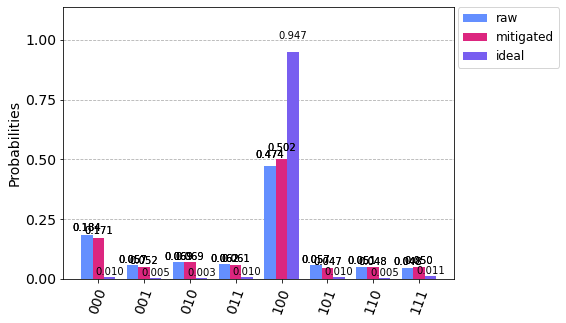

In [104]:
plot_histogram([counts_run_santiago, mitigated_counts, counts_sim2], legend=['raw', 'mitigated', 'ideal'])